In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch

from network import Net
from diff_equations import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(69)
np.random.seed(69)


Text(0.5, 0, 'Time (s)')

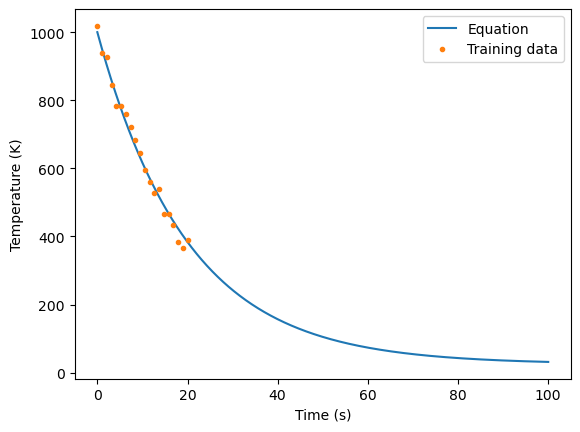

In [2]:
Tenv = 25
T0 = 1000
R = 0.05
times = np.linspace(0, 100, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 20, 20)
y = eq(t) + 20 * np.random.randn(20)

plt.plot(times, temps)
plt.plot(t, y, '.')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')


# Vanilla Network

Epoch 0/1000, loss: 449570.97
Epoch 100/1000, loss: 63287.71
Epoch 200/1000, loss: 884.10
Epoch 300/1000, loss: 558.59
Epoch 400/1000, loss: 429.01
Epoch 500/1000, loss: 353.57
Epoch 600/1000, loss: 307.68
Epoch 700/1000, loss: 283.50
Epoch 800/1000, loss: 266.23
Epoch 900/1000, loss: 252.89


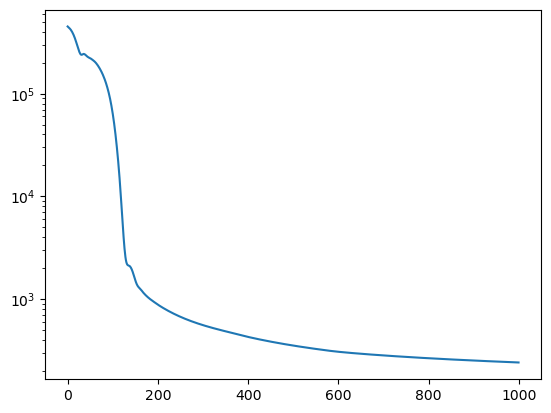

In [14]:
net = Net(1,1, pde_loss=None, epochs=1000, lr=5e-3).to(DEVICE)

losses = net.fit(t, y)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

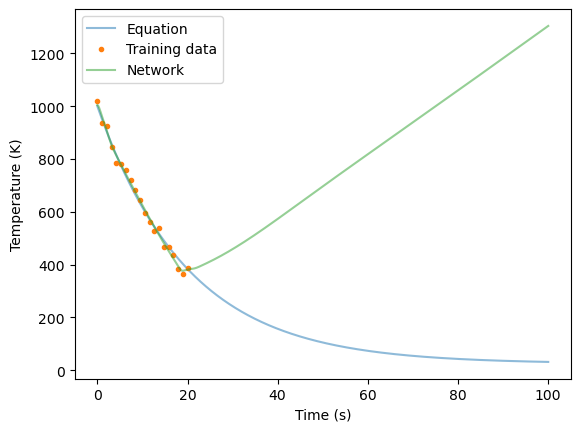

In [15]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.5)
plt.plot(t, y, '.')
plt.plot(times, preds, alpha=0.5)
plt.legend(labels=['Equation','Training data', 'Network'])
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')

# Standard L2 Regularisation

In [29]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

Epoch 0/1000, loss: 449565.84
Epoch 100/1000, loss: 28542.30
Epoch 200/1000, loss: 919.35
Epoch 300/1000, loss: 623.88
Epoch 400/1000, loss: 541.50
Epoch 500/1000, loss: 505.31
Epoch 600/1000, loss: 483.99
Epoch 700/1000, loss: 468.23
Epoch 800/1000, loss: 454.55
Epoch 900/1000, loss: 440.93


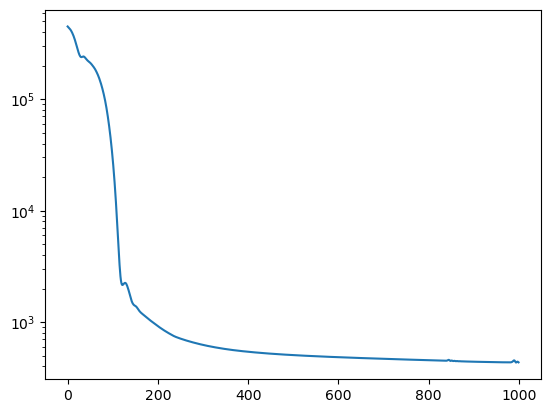

In [30]:
net = Net(1,1, pde_loss=l2_reg, epochs=1000, lr=5e-3, phys_weight=0.01).to(DEVICE)

losses = net.fit(t, y)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

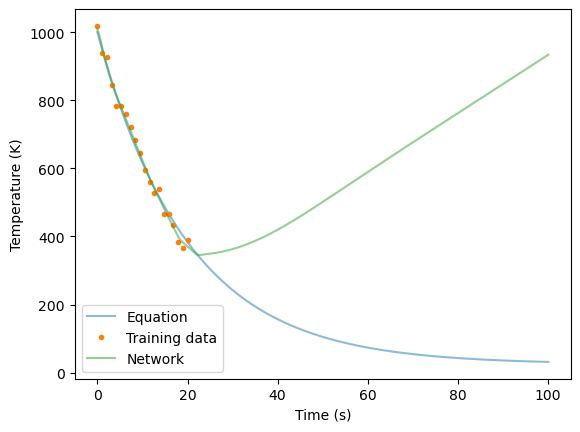

In [31]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.5)
plt.plot(t, y, '.')
plt.plot(times, preds, alpha=0.5)
plt.legend(labels=['Equation','Training data', 'Network'])
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')

# PINN

In [5]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 100, steps=30,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT
    del ts
    return torch.mean(pde**2)

Epoch 0/1000, loss: 447836.19
Epoch 100/1000, loss: 61511.39
Epoch 200/1000, loss: 980.97
Epoch 300/1000, loss: 494.36
Epoch 400/1000, loss: 368.06
Epoch 500/1000, loss: 326.78
Epoch 600/1000, loss: 310.56
Epoch 700/1000, loss: 294.10
Epoch 800/1000, loss: 275.86
Epoch 900/1000, loss: 265.94


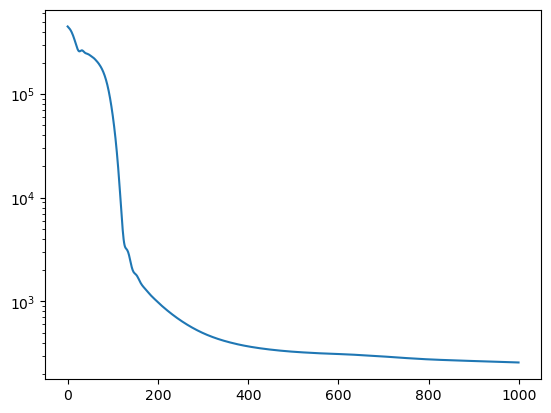

In [12]:
net = Net(1,1, pde_loss=physics_loss, epochs=1000, phys_weight=1, lr=5e-3).to(DEVICE)

losses = net.fit(t, y)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

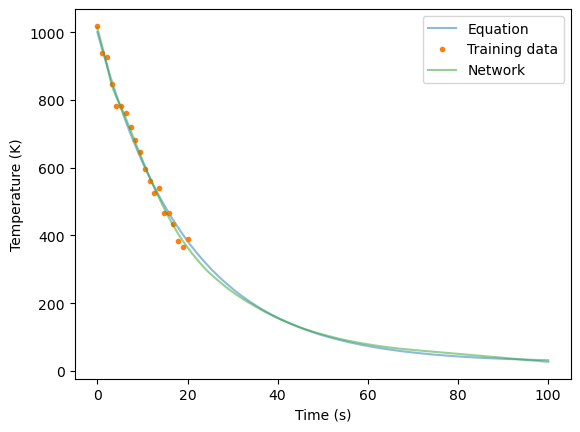

In [13]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.5)
plt.plot(t, y, '.')
plt.plot(times, preds, alpha=0.5)
plt.legend(labels=['Equation','Training data', 'Network'])
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')